## Data from sediment 
In this notebook we will focus on 2 class classification based on enviromental supplementation.

In [23]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from functions import *
from sklearn.preprocessing import LabelEncoder


In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Sed/sed_bacteria_full_feature_table.csv')
print(df.shape)
print(len(df["pond"].unique()))
df.head()



(50, 228)
25


,pond,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sed_S10,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sed_S11,81.0,21.0,29.0,90.0,NaN,8.0,10.0,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sed_S11,3.0,13.0,18.0,3.0,NaN,3.0,18.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sed_S12,171.0,67.0,109.0,76.0,23.0,31.0,NaN,1.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
#df.drop(columns=["class"], inplace=True)
df.insert(1,"class_timepoint",  classes)

After the data look and checkup we can see that the dataset cosists of 227 bacteria famillies (columns) which we will treat as features, and 50 rows holding 25 unique values each of those represents one pond, ponds are divided into 5 different experimental setups we will have to decode that. Also there are two values per pond which indicate two points in time. We will perform classification between those two points to see if model is able to notice any significant changes and if it does use feature selection methods to see which bacteria is impacted by time alone regardless of supplementation. Later we will perform classification based on different experimental setups on both timepoints (one timepoint at the time) to see if there are changes between those.  

In [26]:
df.fillna(0, inplace=True)
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,103.480000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,0.505076,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,127.867636,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,3.250000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,51.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,196.750000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,463.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [27]:
classes = np.tile([0, 1], 25)
#df.drop(columns=["class"], inplace=True)
df.insert(1,"timepoint",  classes)

In [28]:
predictors = df.columns[3:]

In [29]:
df_norm = df.copy()
X_norm = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df_norm[predictors] = X_norm

### Modeling differences between Classes for both timepoints at the same time

In [30]:

def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

In [31]:
df.head()

,pond,timepoint,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
codes = {0 : [8,14,18,24,29,9,13,17,20,27,11,15,22,25,31], 1: [12,16,19,23,26,10,21,28,30,32]}

df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


C:\Users\marek\AppData\Local\Temp\ipykernel_13464\805454141.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [33]:
X = df[predictors].values
y=df["class_pond"].values
yt = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(35, 227) (15, 227) (35, 2) (15, 2)


In [34]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,890 (296.45 KB)

 Trainable params: 75,890 (296.45 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [36]:
history2=model2.fit(X_train, y_train, epochs = 45, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.4315 - loss: 11.5261 - val_accuracy: 0.4000 - val_loss: 8.7190
Epoch 2/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4610 - loss: 9.7700 - val_accuracy: 0.4000 - val_loss: 7.5993
Epoch 3/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5286 - loss: 10.7612 - val_accuracy: 0.4667 - val_loss: 6.9262
Epoch 4/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4905 - loss: 11.0017 - val_accuracy: 0.4667 - val_loss: 6.4925
Epoch 5/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4801 - loss: 10.4210 - val_accuracy: 0.4000 - val_loss: 6.2807
Epoch 6/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5685 - loss: 8.5977 - val_accuracy: 0.4000 - val_loss: 6.1956
Epoch 7/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4610 - loss: 8.5191 - val_accuracy: 0.4000 - val_loss: 6.0663
Epoch 8/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5095 - loss: 4.7782 - val_accuracy: 0.4000 - val_loss: 5.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5333 - loss: 7.1753
[7.175347328186035, 0.5333333611488342]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted values: [1 0 1 1 1 1 0 1 1 1 1 0 1 0 1]
True values: [1 1 0 0 0 1 0 1 1 0 1 0 0 0 0]


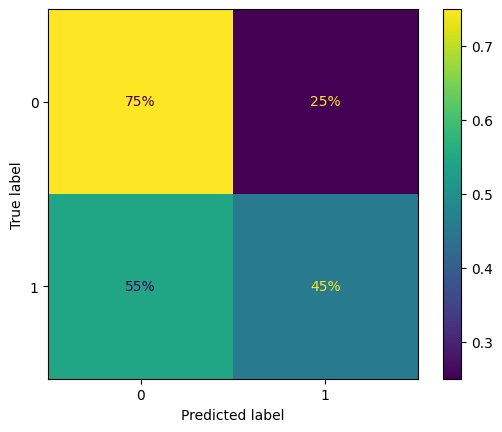

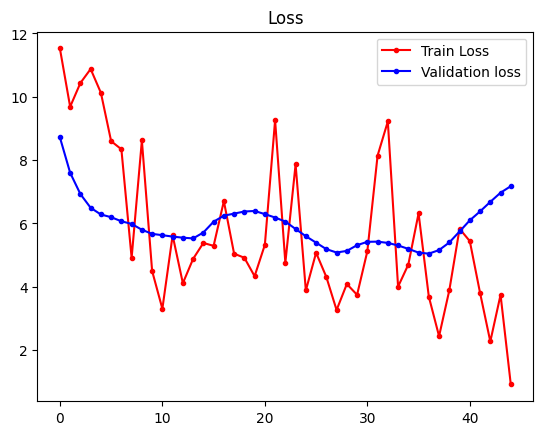

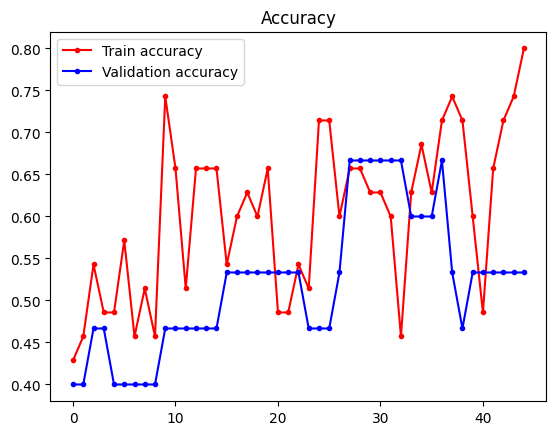

In [37]:
evaluate_model(model2, history2, X_test, y_test)

Here we can see that accuracy is much better, although we have to note that as we have only 2 classes and overrepresentation of class 0, by assigning all og our observation to class 0 we would end up with accuracy of 30/50 so 60%, and that's what's happening in end model, so although loss curve for validation doesnt seem to show overfitting, there seem to be a probblem with the model. we could implement early stopping callback to find accuracy and loss peak at around 25 epochs. Model confusion can also be caused by mixing two timepoints. From biological POV there should be differences between them which we are not taking into account. Lets fix that.


### Modeling class differences in second timepoint

In this section we will classify based on differences in between enviromental supplementation in second timepoint only. biologicaly there should be more differences on this timepoint as enviroment had timne to react to supplementation.

In [38]:
df_second_tp = df_norm[df_norm["class_timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 231)


,pond,timepoint,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,Sed_S10,1,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Sed_S11,1,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,Sed_S12,1,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Sed_S13,1,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,Sed_S14,1,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [41]:
X=df_second_tp[predictors].values
y=df_second_tp["class_pond"].values
yt = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(15, 227) (10, 227) (15, 2) (10, 2)


In [61]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(2, activation ='softmax'))

model3.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,890 (296.45 KB)

 Trainable params: 75,890 (296.45 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [63]:
history3=model3.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2667 - loss: 0.7352 - val_accuracy: 0.4000 - val_loss: 0.6909
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1333 - loss: 0.7508 - val_accuracy: 0.6000 - val_loss: 0.6906
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2667 - loss: 0.7177 - val_accuracy: 0.6000 - val_loss: 0.6904
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4000 - loss: 0.7253 - val_accuracy: 0.6000 - val_loss: 0.6903
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5333 - loss: 0.6900 - val_accuracy: 0.6000 - val_loss: 0.6902
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3333 - loss: 0.7100 - val_accuracy: 0.6000 - val_loss: 0.6900
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4667 - loss: 0.6979 - val_accuracy: 0.6000 - val_loss: 0.6896
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4667 - loss: 0.7008 - val_accuracy: 0.6000 - val_loss:

In [64]:
predictions = model3.predict(X_test)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
[[0.5277968  0.47220322]
 [0.5765124  0.42348766]
 [0.5913739  0.40862605]
 [0.92981124 0.07018875]
 [0.73541164 0.26458842]
 [0.8168234  0.18317659]
 [0.59730595 0.402694  ]
 [0.5845948  0.41540527]
 [0.33962882 0.6603712 ]
 [0.86344826 0.13655177]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5000 - loss: 0.9683
[0.968256950378418, 0.5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted values: [0 0 0 0 0 0 0 0 1 0]
True values: [0 1 1 1 0 0 0 0 0 1]


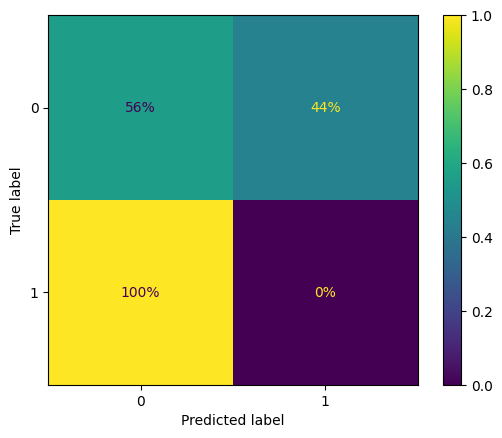

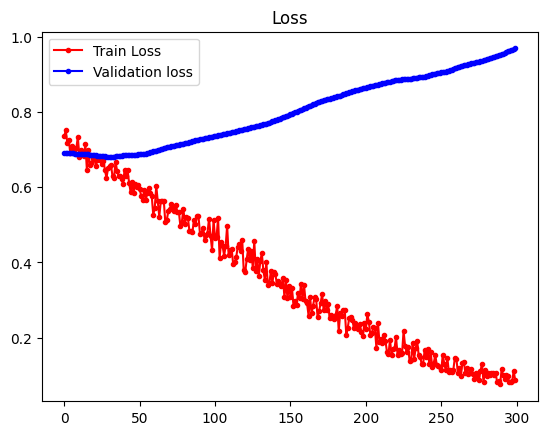

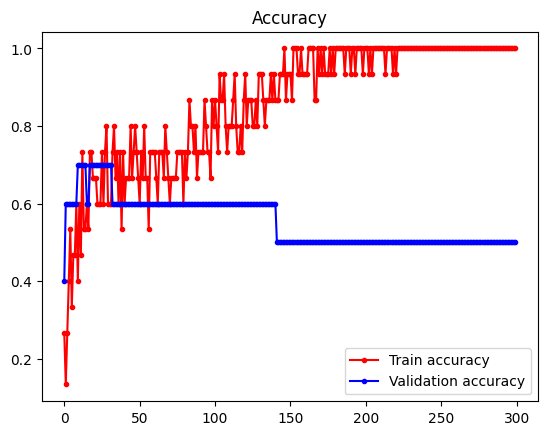

In [65]:
evaluate_model(model3, history3, X_test, y_test)

The results are finally good, There is big overfitting prpoblem caused probably by low (15) sample size for training nevertheless end accuracy of stable 0.8 is promissing. We should now check if the model will baheave the same way for first timepoint, with lower if any differences between classes. 

### Modeling class differences in first timepoint

In this section we will atempt to classify based on first timepoint data, untill this time bad classification results on both timepoints suggest that there are differences between timepoints, we had good classsification on second timepoint so we can note that there are differences between classes. Now we haave to check if there are any differences on first timepoint.

In [50]:
df_first_tp = df_norm[df_norm["class_timepoint"]==0]
print(df_first_tp.shape)
df_second_tp.head()

(25, 231)


,pond,timepoint,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,Sed_S10,1,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Sed_S11,1,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,Sed_S12,1,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,Sed_S13,1,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,Sed_S14,1,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [51]:
X=df_first_tp[predictors].values
y=df_first_tp["class_pond"].values
yt = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(15, 227) (10, 227) (15, 2) (10, 2)


In [52]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(2, activation ='softmax'))

model4.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,890 (296.45 KB)

 Trainable params: 75,890 (296.45 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)


In [54]:
history4 = model4.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 0.8515 - val_accuracy: 0.4000 - val_loss: 0.7621
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4000 - loss: 0.8205 - val_accuracy: 0.4000 - val_loss: 0.7576
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4000 - loss: 0.8508 - val_accuracy: 0.4000 - val_loss: 0.7534
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4000 - loss: 0.8040 - val_accuracy: 0.4000 - val_loss: 0.7497
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4000 - loss: 0.8203 - val_accuracy: 0.4000 - val_loss: 0.7462
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3333 - loss: 0.8354 - val_accuracy: 0.4000 - val_loss: 0.7427
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4000 - loss: 0.7717 - val_accuracy: 0.4000 - val_loss: 0.7397
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4000 - loss: 0.7903 - val_accuracy: 0.4000 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3000 - loss: 0.9365
[0.9364503026008606, 0.30000001192092896]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted values: [1 0 0 0 0 0 0 1 1 0]
True values: [0 1 1 1 0 0 0 0 0 1]


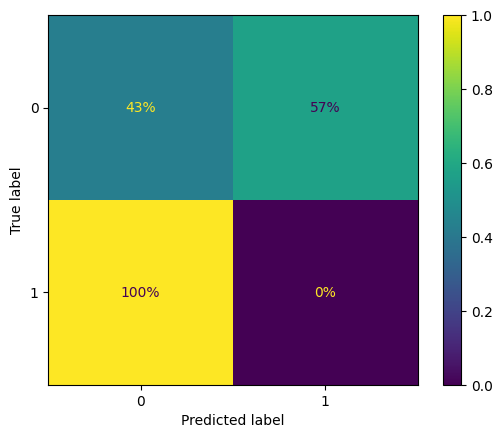

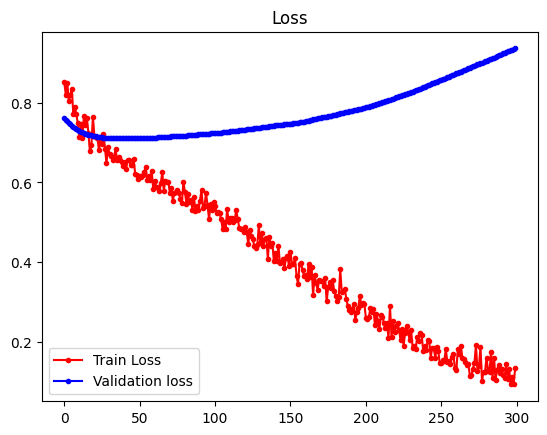

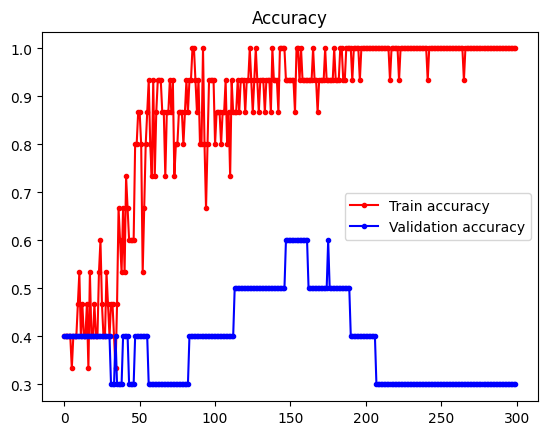

In [57]:
evaluate_model(model4, history4, X_test, y_test)

In [29]:
df["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)

C:\Users\marek\AppData\Local\Temp\ipykernel_12108\1246733335.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepoint*pond"] = df["class_timepoint"].astype(str) + "_" + df["class_pond"].astype(str)


In [30]:
len(df["class_timepoint*pond"].unique())

10

In [31]:
X=df[predictors].values
y=df["class_timepoint*pond"].values
y = LabelEncoder().fit_transform(y)
y
yt = keras.utils.to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X,yt,test_size=10,random_state=111,stratify = y,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(40, 227) (10, 227) (40, 10) (10, 10)


In [35]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(10, activation ='softmax'))

model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,026 (296.98 KB)

 Trainable params: 76,026 (296.98 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [39]:
history4=model4.fit(X_train, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test, y_test))

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2667 - loss: 4.1243 - val_accuracy: 0.2000 - val_loss: 4.2980
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2708 - loss: 3.2869 - val_accuracy: 0.2000 - val_loss: 4.2802
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3542 - loss: 4.1701 - val_accuracy: 0.2000 - val_loss: 4.2684
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2292 - loss: 4.9528 - val_accuracy: 0.2000 - val_loss: 4.2440
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2333 - loss: 4.1106 - val_accuracy: 0.2000 - val_loss: 4.2116
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3208 - loss: 4.8887 - val_accuracy: 0.2000 - val_loss: 4.1873
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3417 - loss: 3.4968 - val_accuracy: 0.2000 - val_loss: 4.1748
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2938 - loss: 3.2503 - val_accuracy: 0.2000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1000 - loss: 4.1775
[4.177490711212158, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [2 6 0 3 6 6 8 6 8 8]
True values: [6 2 9 0 7 5 4 3 1 8]


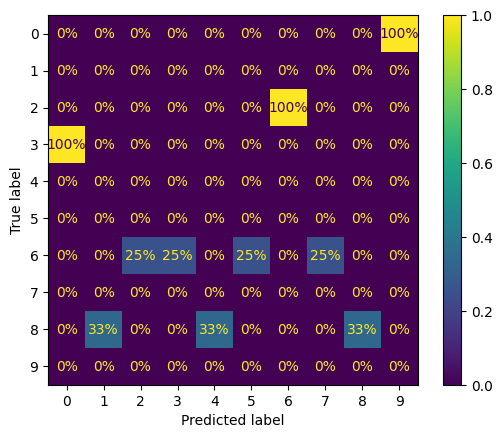

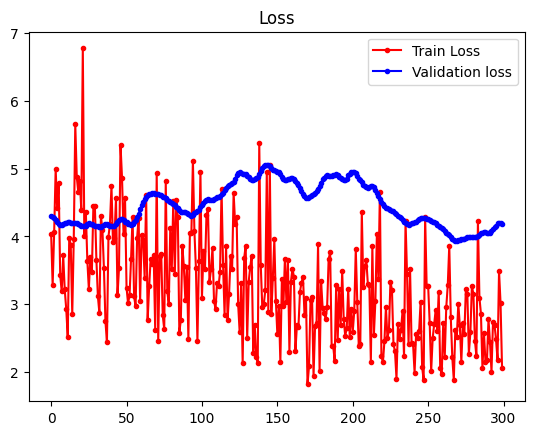

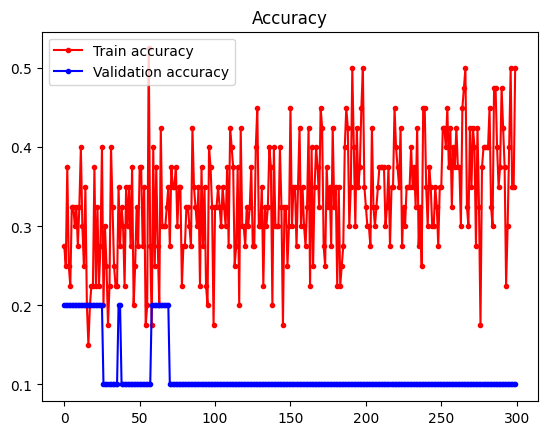

In [40]:
evaluate_model(model4, history4, X_test, y_test)

Although we dont see signs of overfitting accuracy is lackluster either, close to random. We will now reuse 2 class classification approach from gut dataset. This time we will use enviromental.
supplementation as class. This will be in next notebook Sediment_2.ipynb

,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond,class_timepoint*pond
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0_2
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1_2
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0_4
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1_4
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0_1
5,Sed_S12,1,47.0,88.0,24.0,42.0,0.0,2.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1_1
6,Sed_S13,0,64.0,185.0,0.0,74.0,11.0,19.0,60.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0_3
7,Sed_S13,1,140.0,113.0,374.0,67.0,3.0,86.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1_3
8,Sed_S14,0,35.0,69.0,15.0,3.0,0.0,0.0,41.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0_0
9,Sed_S14,1,181.0,220.0,249.0,47.0,23.0,42.0,40.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1_0
